In [1]:
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt


In [2]:
def load_nn(tspec): 
    magic_line="4_1_4096_3_0.25_8_mse_0.0001_0.05_sub_{}_{}_{}.npy".format(
    tspec['training_day'],tspec['training_validation_length'],tspec['validation_split'])
    fn = 'npys/ypred_conv2d_tpsuvq_online_'+varn+'_'+magic_line
    print(fn)
    y_pred_nn = np.load(fn)
    return y_pred_nn

In [3]:
def load_linear(ts, y, start_day, end_day):
    y_shape=y.shape
    y_pred_linear = np.empty(y_shape)
        
    #loop over 4 timeslots in one day
    for offset in range(4):
        y_avv=np.mean(y[np.where(ts==start_day)[0][0]+offset:np.where(ts==end_day)[0][0]:4],axis=0)
        num_inserts=ts[offset:None:4].shape[0]
        y_pred_linear[offset:None:4,...]=np.repeat(y_avv[np.newaxis,:,:,:],num_inserts,axis=0)

    return y_pred_linear

In [4]:
def compute_skill(y, y_pred, ts, training_day, pred_window):
    y_pred_ts=y_pred.view().reshape((y.shape[0], np.prod(y.shape[1:])))
    y_ts=y.view().reshape((y.shape[0], np.prod(y.shape[1:])))
    
    tmp = 1-np.mean((y_pred_ts-y_ts)**2,axis=1)/np.mean((y_ts)**2,axis=1)
    skill = np.mean(tmp[np.where(ts==training_day)[0][0]+pred_window[0]:np.where(ts==training_day)[0][0]+pred_window[1]])
    return skill

In [5]:
#paramenter block 
varn='t'
training_lengths=np.array([1, 3, 7, 14, 30, 90, 365])
training_day=375
pred_window=np.array([0 ,14])



In [6]:
#load truth 
tspec=dict()
tspec['training_day']=375
tspec['training_validation_length']=365
tspec['validation_split']=0.7
magic_line="4_1_4096_3_0.25_8_mse_0.0001_0.05_sub_{}_{}_{}.npy".format(
    tspec['training_day'],tspec['training_validation_length'],tspec['validation_split'])

y = np.load('npys/y_conv2d_tpsuvq_online_'+varn+'_'+magic_line)
ts = np.arange(y.shape[0])/4


In [7]:
#compute y linear
y_pred_linear=[]
for i in range(1,training_lengths.size):
    start_day = training_day-training_lengths[i]
    end_day = training_day
    y_pred_linear.append(load_linear(ts, y, start_day, end_day))

#use entire previous season
min_day=10
start_day=max(min_day,training_day-(365+45))
end_day=start_day+90
y_pred_linear_baseline = load_linear(ts, y, start_day, end_day)

In [8]:
# compute linear skill
skill_linear=np.zeros(training_lengths.size);skill_linear.fill(np.nan)
for i in range(len(y_pred_linear)):
    skill_linear[i+1]=compute_skill(y, y_pred_linear[i], ts, training_day, pred_window) 
display(skill_linear)

array([        nan, -0.12795166,  0.02349841,  0.08145935, -0.01023012,
        0.05858415,  0.04450424])

In [9]:
#compute linear skill for seasonal baseline
skill_linear_baseline = compute_skill(y, y_pred_linear_baseline, ts, training_day, pred_window)
skill_linear_baseline2 = compute_skill(y, y_pred_linear_baseline, ts, training_day, pred_window+14)

In [10]:
# load NN results
y_pred_nn=[]
for i in range(training_lengths.size):
  tspec['training_validation_length']=training_lengths[i]
  y_pred_nn.append(load_nn(tspec))


npys/ypred_conv2d_tpsuvq_online_t_4_1_4096_3_0.25_8_mse_0.0001_0.05_sub_375_1_0.7.npy
npys/ypred_conv2d_tpsuvq_online_t_4_1_4096_3_0.25_8_mse_0.0001_0.05_sub_375_3_0.7.npy
npys/ypred_conv2d_tpsuvq_online_t_4_1_4096_3_0.25_8_mse_0.0001_0.05_sub_375_7_0.7.npy
npys/ypred_conv2d_tpsuvq_online_t_4_1_4096_3_0.25_8_mse_0.0001_0.05_sub_375_14_0.7.npy
npys/ypred_conv2d_tpsuvq_online_t_4_1_4096_3_0.25_8_mse_0.0001_0.05_sub_375_30_0.7.npy
npys/ypred_conv2d_tpsuvq_online_t_4_1_4096_3_0.25_8_mse_0.0001_0.05_sub_375_90_0.7.npy
npys/ypred_conv2d_tpsuvq_online_t_4_1_4096_3_0.25_8_mse_0.0001_0.05_sub_375_365_0.7.npy


In [11]:
# compute NN skill for week 1-2
skill_nn=np.zeros(training_lengths.size);skill_nn.fill(np.nan)
for i in range(training_lengths.size):
  skill_nn[i]=compute_skill(y, y_pred_nn[i], ts, training_day, pred_window)
display(skill_nn)

array([0.05592212, 0.07012581, 0.09306722, 0.10502612, 0.03575703,
       0.12870023, 0.14925119])

In [12]:
# compute NN skill for week 3-4
skill_nn2=np.zeros(training_lengths.size);skill_nn2.fill(np.nan)
for i in range(training_lengths.size):
  skill_nn2[i]=compute_skill(y, y_pred_nn[i], ts, training_day, pred_window+14)
display(skill_nn2)

array([0.03441801, 0.04035707, 0.0694627 , 0.08093508, 0.0279917 ,
       0.10679408, 0.14581946])

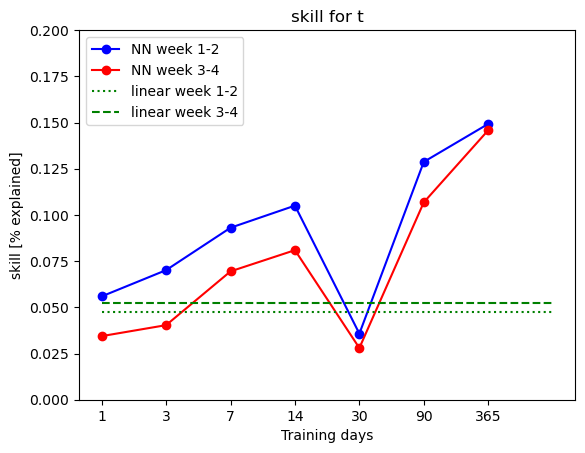

In [13]:
fig, ax = plt.subplots()
ax.plot(skill_nn,'bo-')
ax.plot(skill_nn2,'ro-')
#ax.plot(skill_linear,'mo-')
ax.plot(np.array([0, skill_nn.size]), skill_linear_baseline*np.array([1, 1]),'g:')
ax.plot(np.array([0, skill_nn.size]), skill_linear_baseline2*np.array([1, 1]),'g--')
ax.set_ylim(-0.0,0.2)
ax.set_xticks(range(training_lengths.size))
ax.set_xticklabels(training_lengths.astype('str'))
ax.set_xlabel('Training days')
ax.set_ylabel('skill [% explained]')
ax.set_title(f"skill for {varn}")
ax.legend(['NN week 1-2','NN week 3-4','linear week 1-2','linear week 3-4'])